#### Classificador de gravidade de vítimas em uma situação de resgate
##### Equipe: Juliana Viscenheski, Maria Fernanda Azolin, Mariana Bittencourt Junghans

#### Classificador 1: Decision Tree

In [ ]:
#libraries for data manipulation
import pandas as pd   
import numpy as np

#libraries for prediction and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

#library for the decision tree
from sklearn import tree

#library for oversampling
from imblearn.over_sampling import RandomOverSampler, SMOTE

#libraries for visualization
import graphviz

In [ ]:
# library to save the models
import joblib

In [ ]:
#set maximum columns for visualization
pd.options.display.max_columns = 50

In [ ]:
# read the data
df_victims = pd.read_csv('env_vital_signals.txt', delimiter=',',header=None)

In [ ]:
# visualize the dataframe
df_victims.head()

In [ ]:
#Set the column names
df_victims.columns = ['Id','pSist','pDiast','qPA','pulso','resp','grav','label']

In [ ]:
# visualize the dataframe
df_victims.head()

In [ ]:
df_victims['label'].value_counts()

In [ ]:
#Check the dataframe info
df_victims.info()

In [ ]:
#Discard the columns that are not going to be used for prediction
df_victims.drop(['pSist','pDiast','grav'], axis=1, inplace=True)

In [ ]:
# visualize the dataframe
df_victims.head()

In [ ]:
#Check the dataframe metrics
df_victims.describe()

In [ ]:
# visualize the dataframe
df_victims.head()

In [ ]:
# Select data for modeling
X=df_victims.drop(['label'], axis=1)
y=df_victims['label']

In [ ]:
# Instantiate the random oversampler
oversampler = SMOTE(random_state=42)

# Fit and apply the random oversampler
X, y = oversampler.fit_resample(X, y)

In [ ]:
# Create a decision tree classifier
clf = tree.DecisionTreeClassifier(max_depth=10)

In [ ]:
# Perform cross-validation with 5 folds
scores = cross_val_score(clf, X, y, cv=5)  # 5-fold cross-validation

In [ ]:
print("Cross-validation scores:", scores)

In [ ]:
# Split the data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# Fit the model with train data
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred, target_names=['Crítico','Instável','Potencialmente estável','Estável']))

In [ ]:
# Use graphviz to plot the tree
dot_data = tree.export_graphviz(clf, out_file=None,
feature_names=X.columns,
class_names=['Crítico','Instável','Potencialmente estável','Estável'],
filled=True,
rounded=True)
graph = graphviz.Source(dot_data)

graph

#### Pré-teste cego com 800 vítimas

In [ ]:
df_test = pd.read_csv('env_vital_signals_test.txt',sep=',',header=None)

In [ ]:
df_test.head()

In [ ]:
#Set the column names
df_test.columns = ['Id','pSist','pDiast','qPA','pulso','resp','grav','label']

In [ ]:
#Discard the columns that are not going to be used for prediction
df_test.drop(['pSist','pDiast','grav'], axis=1, inplace=True)

In [ ]:
# Select data for modeling
X=df_test.drop(['label'], axis=1)
y=df_test['label']

In [ ]:
# Predict for the 800 victim dataset
y_pred2 = clf.predict(X)

In [ ]:
print(classification_report(y, y_pred2, target_names=['Crítico','Instável','Potencialmente estável','Estável']))

In [ ]:
df_test.head()

In [ ]:
# Create the dataframe to generate the output file
df_predicted = pd.DataFrame(columns=['Id','x','y','grav','classe'])

In [ ]:
df_predicted

In [ ]:
# Set the Id column
df_predicted['Id'] = df_test['Id']

In [ ]:
# Set x, y, grav columns as zero
df_predicted['x'] = 0
df_predicted['y'] = 0
df_predicted['grav'] = 0

In [ ]:
df_predicted

In [ ]:
# Set the 'classe' column as the predicted labels
df_predicted['classe'] = pd.Series(y_pred2)

In [ ]:
df_predicted

In [ ]:
df_predicted['classe'].value_counts()

In [ ]:
df_predicted.to_csv('pred.txt',sep=',',header=None,index=False)

In [ ]:
# Save the trained model to a file
joblib.dump(clf, 'decision_tree_model.joblib')

#### Classificador 2: Fuzzy

In [3]:
#fuzzy library
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [4]:
#libraries for data manipulation
import numpy as np
import pandas as pd

In [5]:
#libraries for prediction and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

In [6]:
# library to save the models
import joblib

In [124]:
# Create the input variable arrays (universes)
x_qpa = np.arange(-10,11,0.1)
x_pulsacao = np.arange(0,201,1)
x_respiracao = np.arange(0,23,1)
x_gravidade = np.arange(0,101,1)

In [125]:
# Create the input variables for the fuzzy system
qpa = ctrl.Antecedent(x_qpa,'qPA')
pulsacao = ctrl.Antecedent(x_pulsacao,'Pulsacao')
respiracao = ctrl.Antecedent(x_respiracao,'Respiracao')
gravidade = ctrl.Consequent(x_gravidade,'Gravidade')

In [126]:
# Create the membership function for blood pressure
# Partitions:
# -10 <= qPA < -1 igual a Baixa
# -1 <= qPA < 1 igual a Normal
# 1 <= qPA <= 10 igual a Alta
qpa['Baixa'] = fuzz.trimf(x_qpa,[-10,-5,-1])
qpa['Normal'] = fuzz.trimf(x_qpa,[-5,-1,1])
qpa['Alta'] = fuzz.trimf(x_qpa,[-1,1,10])

In [145]:
# Create the membership function for pulsation
# Partitions:
# pulsacao < 60bpm igual a Baixa
# 60 bpm <= pulsacao <= 100bpm igual a Normal
# pulsacao > 100bpm igual a Alta
pulsacao['Baixa'] = fuzz.trimf(x_pulsacao,[0,30,60])
pulsacao['Normal'] = fuzz.trimf(x_pulsacao,[30,60,100])
pulsacao['Alta'] = fuzz.trimf(x_pulsacao,[60,100,200])

In [128]:
# Create the membership function for breathing
# Partitions:
# respiracao < 14fr igual a Baixa
# 14 fr <= respiracao <= 18fr igual a Normal
# respiracao >= 18fr igual a Alta
respiracao['Baixa'] = fuzz.trimf(x_respiracao,[0,7,14])
respiracao['Normal'] = fuzz.trimf(x_respiracao,[7,14,18])
respiracao['Alta'] = fuzz.trimf(x_respiracao,[14,18,22])

In [129]:
# Create the membership function for gravity
# Partitions:
# 0 <= gravidade <= 25 igual a Crítico
# 25 < gravidade <= 50 igual a Instável
# 50 < gravidade <= 75 igual a Potencialmente Estável
# 75 < gravidade <= 100 igual a Estável
gravidade['Crítico'] = fuzz.trimf(x_gravidade,[0,12.5,25])
gravidade['Instável'] = fuzz.trimf(x_gravidade,[12.5,25,50])
gravidade['Potencialmente Estável'] = fuzz.trimf(x_gravidade,[25,50,75])
gravidade['Estável'] = fuzz.trimf(x_gravidade,[50,75,100])

C:\Users\mbitt\OneDrive\Mestrado\IA\Fuzzy\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


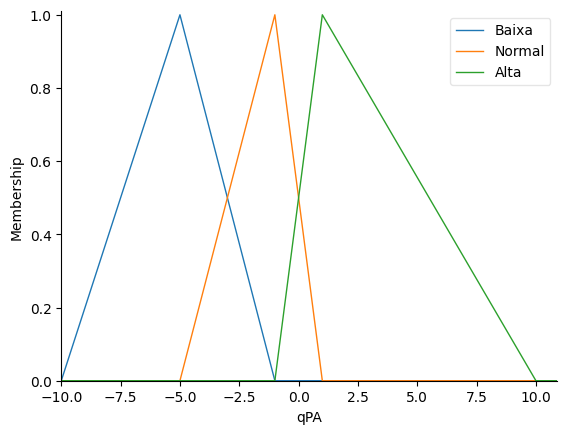

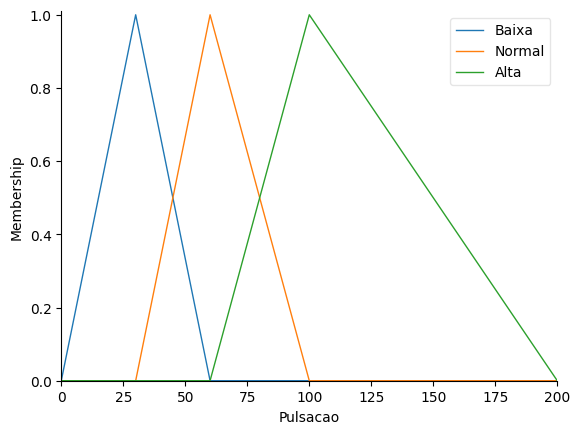

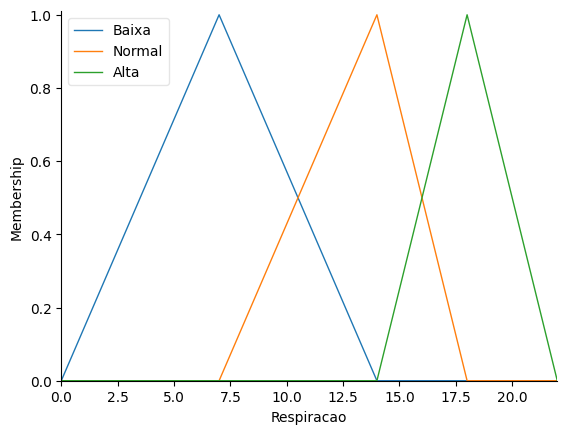

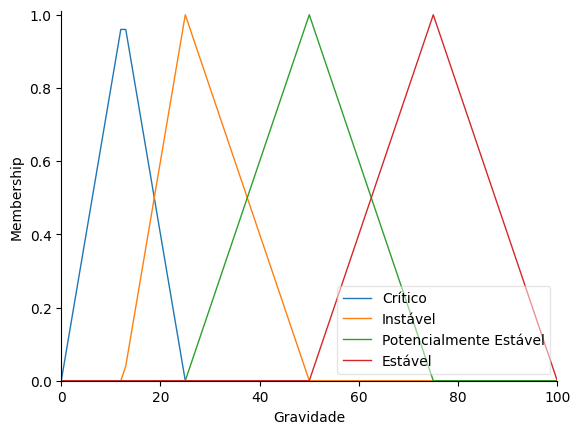

In [146]:
qpa.view()
pulsacao.view()
respiracao.view()
gravidade.view()

In [227]:
#Creation of the fuzzy rules
# Possible values:
# qPA: Baixa, Normal, Alta
# Pulsação: Baixa, Normal, Alta
# Respiração: Baixa, Normal, Alta
rule1 = ctrl.Rule(qpa['Baixa'] & pulsacao['Baixa'] & respiracao['Baixa'], gravidade['Crítico'])
rule2 = ctrl.Rule(qpa['Baixa'] & pulsacao['Baixa'] & respiracao['Normal'], gravidade['Instável'])
rule3 = ctrl.Rule(qpa['Baixa'] & pulsacao['Baixa'] & respiracao['Alta'], gravidade['Crítico'])
rule4 = ctrl.Rule(qpa['Baixa'] & pulsacao['Normal'] & respiracao['Baixa'], gravidade['Instável'])
rule5 = ctrl.Rule(qpa['Baixa'] & pulsacao['Normal'] & respiracao['Normal'], gravidade['Instável'])
rule6 = ctrl.Rule(qpa['Baixa'] & pulsacao['Normal'] & respiracao['Alta'], gravidade['Instável'])
rule7 = ctrl.Rule(qpa['Baixa'] & pulsacao['Alta'] & respiracao['Baixa'], gravidade['Crítico'])
rule8 = ctrl.Rule(qpa['Baixa'] & pulsacao['Alta'] & respiracao['Normal'], gravidade['Instável'])
rule9 = ctrl.Rule(qpa['Baixa'] & pulsacao['Alta'] & respiracao['Alta'], gravidade['Crítico'])
rule10 = ctrl.Rule(qpa['Normal'] & pulsacao['Baixa'] & respiracao['Baixa'], gravidade['Instável'])
rule11 = ctrl.Rule(qpa['Normal'] & pulsacao['Baixa'] & respiracao['Normal'], gravidade['Instável'])
rule12 = ctrl.Rule(qpa['Normal'] & pulsacao['Baixa'] & respiracao['Alta'], gravidade['Potencialmente Estável'])
rule13 = ctrl.Rule(qpa['Normal'] & pulsacao['Normal'] & respiracao['Baixa'], gravidade['Potencialmente Estável'])
rule14 = ctrl.Rule(qpa['Normal'] & pulsacao['Normal'] & respiracao['Normal'], gravidade['Estável'])
rule15 = ctrl.Rule(qpa['Normal'] & pulsacao['Normal'] & respiracao['Alta'], gravidade['Potencialmente Estável'])
rule16 = ctrl.Rule(qpa['Normal'] & pulsacao['Alta'] & respiracao['Baixa'], gravidade['Potencialmente Estável'])
rule17 = ctrl.Rule(qpa['Normal'] & pulsacao['Alta'] & respiracao['Normal'], gravidade['Potencialmente Estável'])
rule18 = ctrl.Rule(qpa['Normal'] & pulsacao['Alta'] & respiracao['Alta'], gravidade['Instável'])
rule19 = ctrl.Rule(qpa['Alta'] & pulsacao['Baixa'] & respiracao['Baixa'], gravidade['Crítico'])
rule20 = ctrl.Rule(qpa['Alta'] & pulsacao['Baixa'] & respiracao['Normal'], gravidade['Instável'])
rule21 = ctrl.Rule(qpa['Alta'] & pulsacao['Baixa'] & respiracao['Alta'], gravidade['Crítico'])
rule22 = ctrl.Rule(qpa['Alta'] & pulsacao['Normal'] & respiracao['Baixa'], gravidade['Instável'])
rule23 = ctrl.Rule(qpa['Alta'] & pulsacao['Normal'] & respiracao['Normal'], gravidade['Instável'])
rule24 = ctrl.Rule(qpa['Alta'] & pulsacao['Normal'] & respiracao['Alta'], gravidade['Instável'])
rule25 = ctrl.Rule(qpa['Alta'] & pulsacao['Alta'] & respiracao['Baixa'], gravidade['Instável'])
rule26 = ctrl.Rule(qpa['Alta'] & pulsacao['Alta'] & respiracao['Normal'], gravidade['Instável'])
rule27 = ctrl.Rule(qpa['Alta'] & pulsacao['Alta'] & respiracao['Alta'], gravidade['Crítico'])

In [228]:
# Build fuzzy system
fuzzy_ctrl = ctrl.ControlSystem([rule1,rule2,rule3,rule4,rule5,rule6,rule7,rule8,rule9,rule10,rule11,rule12,
                                  rule13,rule14,rule15,rule16,rule17,rule18,rule19,rule20,rule21,rule22,rule23,
                                  rule24,rule25,rule26,rule27])
fuzzy = ctrl.ControlSystemSimulation(fuzzy_ctrl)

In [229]:
fuzzy.input['qPA'] = 0
fuzzy.input['Pulsacao'] = 80
fuzzy.input['Respiracao'] = 19

36.01190476190475


C:\Users\mbitt\OneDrive\Mestrado\IA\Fuzzy\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


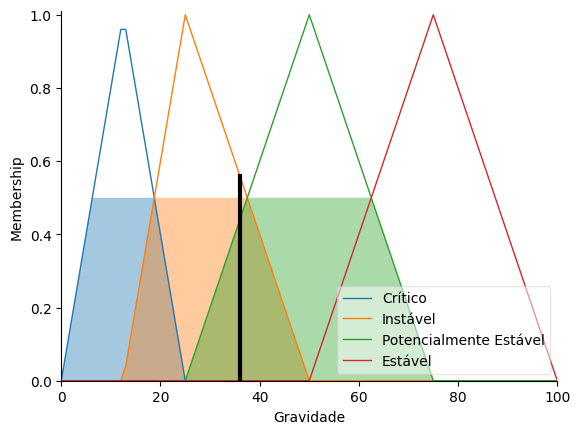

In [230]:
fuzzy.compute()
print(fuzzy.output['Gravidade'])
gravidade.view(sim=fuzzy)

In [158]:
#Load the dataset
df_victims = pd.read_csv('env_vital_signals.txt',header=None)

In [159]:
#Set the column names
df_victims.columns = ['Id','pSist','pDiast','qPA','pulso','resp','grav','label']

In [160]:
df_victims.head()

,Id,pSist,pDiast,qPA,pulso,resp,grav,label
0,0,14.968414,14.869604,8.652291,122.324349,5.623564,25.868691,2
1,1,16.397160,12.220855,8.733333,135.824333,12.787053,35.650207,2
2,2,21.624540,13.586879,8.733333,97.100546,1.553286,37.109058,2
3,3,16.458690,1.904802,-4.333333,6.943670,8.233419,27.122605,2
4,4,18.521669,13.700638,8.733333,22.887924,0.738972,13.222719,1


In [188]:
import seaborn as sns

<Axes: xlabel='qPA', ylabel='Count'>

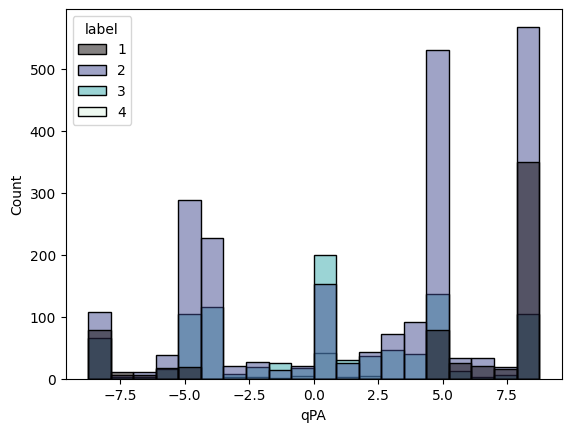

In [197]:
sns.histplot(data=df_victims, x='qPA',hue='label', bins=20, palette='mako')

<Axes: xlabel='pulso', ylabel='Count'>

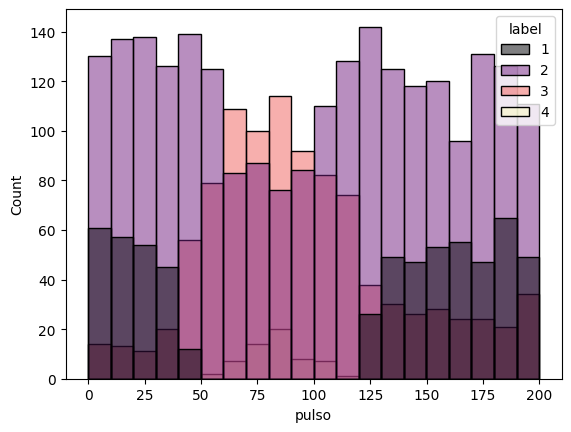

In [198]:
sns.histplot(data=df_victims, x='pulso',hue='label', bins=20, palette='magma')

<Axes: xlabel='resp', ylabel='Count'>

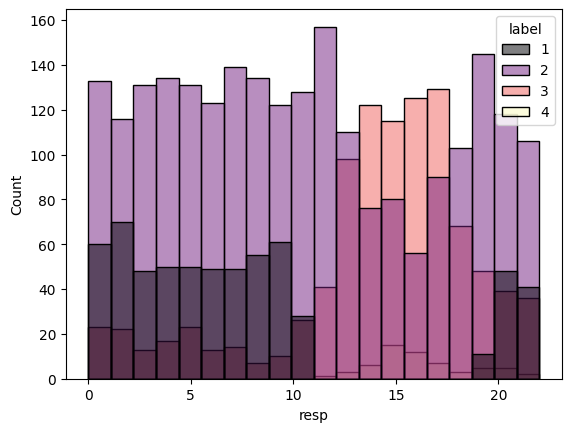

In [199]:
sns.histplot(data=df_victims, x='resp',hue='label', bins=20, palette='magma')

In [161]:
#Discard the columns that are not going to be used for prediction
df_victims.drop(['pSist','pDiast','grav'], axis=1, inplace=True)

In [162]:
# Select data for modeling
X=df_victims.drop(['label'], axis=1)
y=df_victims['label']

In [249]:
# Function to predict the label based on the fuzzy logic
def predict_fuzzy_gravity_label(X):
    predicted = []
    for i in X.index:
        fuzzy.input['qPA'] = X.loc[i,'qPA']
        fuzzy.input['Pulsacao'] = X.loc[i,'pulso']
        fuzzy.input['Respiracao'] = X.loc[i,'resp']
        fuzzy.compute()
        if (fuzzy.output['Gravidade'] >= 0 and fuzzy.output['Gravidade'] <= 25):
            predicted.append(1) #Crítico
        elif (fuzzy.output['Gravidade'] > 25 and fuzzy.output['Gravidade'] <= 50):
            predicted.append(2) #Instável
        elif (fuzzy.output['Gravidade'] > 50 and fuzzy.output['Gravidade'] <= 75):
            predicted.append(3) #Potencialmente estável
        else:
            predicted.append(4) #Estável
    return predicted

In [248]:
# Function to perform k-fold cross-validation using the fuzzy model
def k_fold_cross_validation(X, y, k=5, random_state=None):
    np.random.seed(random_state)
    n = len(X)
    fold_size = n // k
    indices = np.random.permutation(n)
    scores = []
    for i in range(k):
        # Split data into training and testing sets
        test_indices = indices[i * fold_size: (i + 1) * fold_size]
        X_test, y_test = X.loc[test_indices,:], y[test_indices]

        # Evaluate the model on the testing data
        y_pred = predict_fuzzy_gravity_label(X_test)
        correct_predictions = np.sum(y_test == y_pred)
        total_predictions = len(y_test)
        accuracy = correct_predictions / total_predictions
        scores.append(accuracy)
    return scores

In [239]:
scores = k_fold_cross_validation(X,y, random_state=42)

In [240]:
print(scores)

[0.425, 0.415, 0.46625, 0.465, 0.4225]


In [242]:
# Split the data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [246]:
# Predict using fuzzy
y_pred = predict_fuzzy_gravity_label(X_test)

In [247]:
print(classification_report(y_test, y_pred, target_names=['Crítico','Instável','Potencialmente estável','Estável']))

                        precision    recall  f1-score   support

               Crítico       0.26      0.60      0.36       139
              Instável       0.57      0.59      0.58       454
Potencialmente estável       0.67      0.01      0.02       202
               Estável       0.00      0.00      0.00         5

              accuracy                           0.44       800
             macro avg       0.37      0.30      0.24       800
          weighted avg       0.54      0.44      0.40       800



C:\Users\mbitt\OneDrive\Mestrado\IA\Fuzzy\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mbitt\OneDrive\Mestrado\IA\Fuzzy\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mbitt\OneDrive\Mestrado\IA\Fuzzy\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [250]:
df_test = pd.read_csv('env_vital_signals_test.txt',sep=',',header=None)

In [251]:
#Set the column names
df_test.columns = ['Id','pSist','pDiast','qPA','pulso','resp','grav','label']

In [252]:
#Discard the columns that are not going to be used for prediction
df_test.drop(['pSist','pDiast','grav'], axis=1, inplace=True)

In [253]:
# Select data for modeling
X=df_test.drop(['label'], axis=1)
y=df_test['label']

In [254]:
# Predict for the 800 victim dataset
y_pred2 = predict_fuzzy_gravity_label(X)

In [255]:
print(classification_report(y, y_pred2, target_names=['Crítico','Instável','Potencialmente estável','Estável']))

                        precision    recall  f1-score   support

               Crítico       0.20      0.51      0.29       119
              Instável       0.54      0.58      0.56       455
Potencialmente estável       0.38      0.01      0.03       211
               Estável       0.00      0.00      0.00        15

              accuracy                           0.41       800
             macro avg       0.28      0.28      0.22       800
          weighted avg       0.44      0.41      0.37       800



C:\Users\mbitt\OneDrive\Mestrado\IA\Fuzzy\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mbitt\OneDrive\Mestrado\IA\Fuzzy\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mbitt\OneDrive\Mestrado\IA\Fuzzy\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le